# Лабораторная работа №3: Линейные модели. Кросс-валидация.<br>
## Вариант 15 <br>
## ПМИ3-1, Лязер Г.В. <br>

### Условие задачи для варианта 15:
| Вариант | Проверка | Набор данных     | Зависимая переменная       | НОП*                                                                                              | ФОП*                                             |
|:--------:|:--------:|:----------------:|:--------------------------:|:------------------------------------------------------------------------------------------------:|:------------------------------------------------:|
| 15      | K-VAL(5) | College_for_lab  | Grad_Rate / выпускной балл | F_ Top25perc / процент зачисленных студентов, которые в старшей школе относились к топ-25% в диапазоне по освоению F_Undergrad / количество студенческой формы обучения | Private / частный или государственный университет: Да - частный, Нет - государственный | <br> <br>

*НОП, ФОП - объясняющие переменные: НОП - непрерывные, ФОП - фиктивные.

In [5]:
import numpy as np

import pandas as pd

import matplotlib as mpl

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from scipy.stats import shapiro

import time

import sklearn.linear_model as skl_lm

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score


In [9]:
mpl.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [11]:
my_seed = 15

plt = mpl.pyplot

mpl.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

#sns.color_palette('Set2')

In [29]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/College_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (777, 9)


In [30]:
DF_raw.head()

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes


In [31]:
DF_raw.dtypes

Grad_Rate       int64
Accept          int64
Top10perc       int64
Top25perc       int64
F_Undergrad     int64
P_Undergrad     int64
PhD             int64
Expend          int64
Private        object
dtype: object

In [32]:
DF_raw.isna().sum()

Grad_Rate      0
Accept         0
Top10perc      0
Top25perc      0
F_Undergrad    0
P_Undergrad    0
PhD            0
Expend         0
Private        0
dtype: int64

In [38]:
yn_dict = {'Yes' : 1, 'No' : 0}
DF_raw['PrivateYes'] = DF_raw.Private.map(yn_dict)

In [40]:
DF_all = DF_raw[['Grad_Rate', 'Top25perc', 'F_Undergrad', 'PrivateYes']]

In [41]:
DF_all.head()

,Grad_Rate,Top25perc,F_Undergrad,PrivateYes
0,60,52,2885,1
1,56,29,2683,1
2,54,50,1036,1
3,59,89,510,1
4,15,44,249,1


In [43]:
DF_all.dtypes

Grad_Rate      int64
Top25perc      int64
F_Undergrad    int64
PrivateYes     int64
dtype: object

In [44]:
del DF_raw

In [45]:
DF = DF_all.sample(frac = 0.8, random_state=my_seed)

DF_predict = DF_all.drop(DF.index)

In [50]:
DF.groupby('PrivateYes').count()

,Grad_Rate,Top25perc,F_Undergrad
PrivateYes,,,
0,168,168,168
1,454,454,454


### Предварительный анализ данных
#### Считаем Описательные статистики
Расчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `F_Undergrad`, которая является объясняющей перемненной модели, сильно отличается по масштабу от всех остальных. Все показатели положительны.

In [52]:
DF_num = DF.drop('PrivateYes', axis=1)

In [53]:
DF_num.describe()

,Grad_Rate,Top25perc,F_Undergrad
count,622.000000,622.000000,622.000000
mean,66.131833,56.192926,3668.524116
std,17.148644,19.836808,4858.607449
min,10.000000,9.000000,139.000000
25%,54.000000,41.000000,1000.000000
50%,66.000000,54.000000,1707.000000
75%,79.000000,69.000000,3902.250000
max,118.000000,100.000000,31643.000000


#### Строим графики 
Посмотрим на графики взаимного разброса непрерывных переменных.

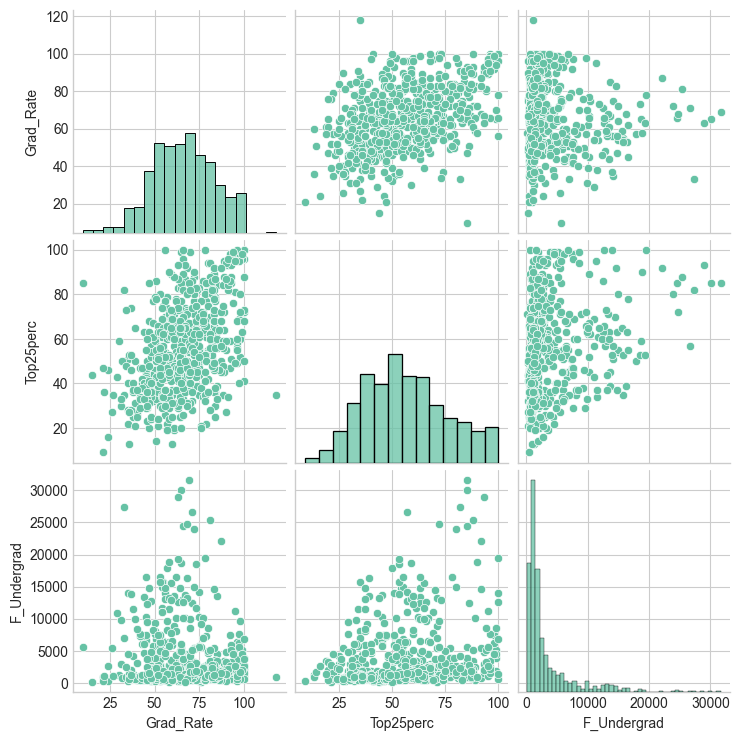

In [54]:
sns.pairplot(DF_num)
plt.show()

Судя по графикам:
- распределение зависимой переменной `Grad_Rate` близко к нормальному;
- распределение объясняющей переменной `Top25perc` близко к нормальному;
- распреление объясняющей переменной `F_Undergrad` не является нормальным.

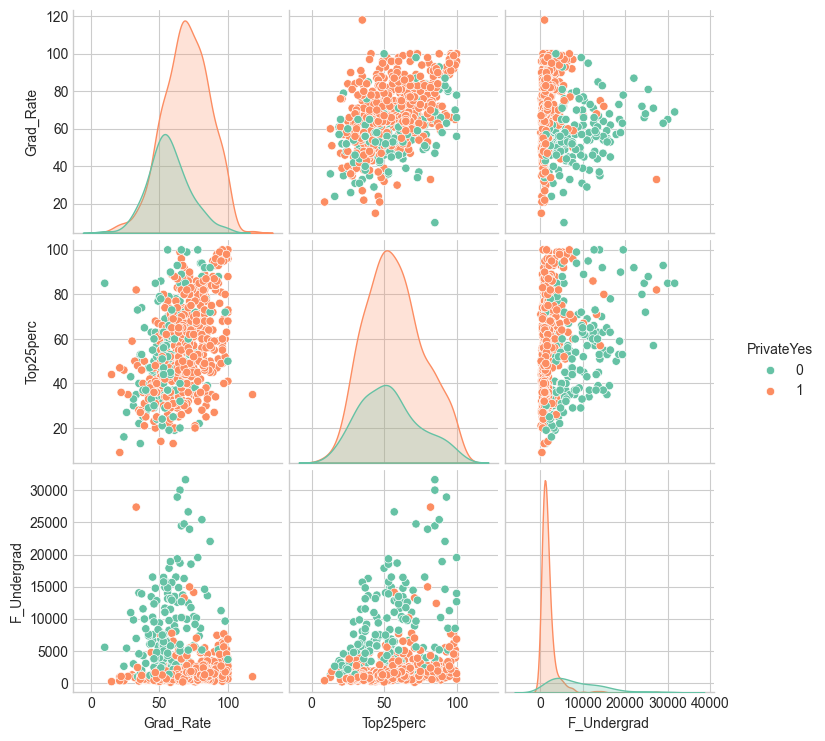

In [49]:
sns.pairplot(DF, hue='PrivateYes')
plt.show()

Из полученных графиков можно заметить, что в срднем значение обясняющей переменной `F_Undergrad` для частных ВУЗов меньше, чем для государственных. Проверим данное предположение, получаем подтверждение данной гипотезы.

In [51]:
DF.groupby('PrivateYes')['F_Undergrad'].mean()

PrivateYes
0    8606.482143
1    1841.262115
Name: F_Undergrad, dtype: float64

Посмотрим на корреляционные матрицы непрерывных переменных фрейма.

In [58]:
corr_mat = DF_num.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.460691,-0.077523
Top25perc,0.460691,1.000000,0.214729
F_Undergrad,-0.077523,0.214729,1.000000


Без разбиения на классы наблюдений по фиктивным переменным максимальная теснота линейной взаимосвязи соответствует коэффициенту корреляции 0.46 между `Grad_Rate` и `Top25perc`.<br>
Посчитаем корреляционные матрицы для частных и государственных ВУЗов.

In [59]:
corr_mat = DF.loc[DF['PrivateYes'] == 1][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.480889,0.142861
Top25perc,0.480889,1.000000,0.317057
F_Undergrad,0.142861,0.317057,1.000000


In [60]:
corr_mat = DF.loc[DF['PrivateYes'] == 0][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.413433,0.270152
Top25perc,0.413433,1.000000,0.441283
F_Undergrad,0.270152,0.441283,1.000000


Заметно, что линейные связи с учетом `PrivateYes` усиливаются для `F_Undergrad` и степени связи объясняющий переменных становятся сопоставимыми. 

#### Проведем тест на нормальность распределения зависимой переменной

In [62]:
stat, p = shapiro(DF['Grad_Rate'])
print('Grad_Rate ', 'Statistics=%.2f, p=%.4f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Распределение нормально (H0 не отклоняется)')
else:
	print('Распределение не нормально (H0 отклоняется)')

Grad_Rate  Statistics=0.99, p=0.0170
Распределение не нормально (H0 отклоняется)


Тест Шапиро-Уилка показывает, что `Grad_Rate` не распределена нормально. Используем логарфмирвание на зависимую переменную и проведем тест повторно.

In [61]:
DF['log_Grad_Rate'] = np.log(DF['Grad_Rate'])
DF_num = DF.drop('PrivateYes', axis=1)

DF_num.describe()

,Grad_Rate,Top25perc,F_Undergrad,log_Grad_Rate
count,622.000000,622.000000,622.000000,622.000000
mean,66.131833,56.192926,3668.524116,4.153006
std,17.148644,19.836808,4858.607449,0.293193
min,10.000000,9.000000,139.000000,2.302585
25%,54.000000,41.000000,1000.000000,3.988984
50%,66.000000,54.000000,1707.000000,4.189655
75%,79.000000,69.000000,3902.250000,4.369448
max,118.000000,100.000000,31643.000000,4.770685


In [63]:
stat, p = shapiro(DF['log_Grad_Rate'])
print('log_Grad_Rate ', 'Statistics=%.2f, p=%.4f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Распределение нормально (H0 не отклоняется)')
else:
	print('Распределение не нормально (H0 отклоняется)')

log_Grad_Rate  Statistics=0.93, p=0.0000
Распределение не нормально (H0 отклоняется)


Тест Шапиро-Уилка показывает, что после логарифмирования `log_Grad_Range` по-прежнему не распределена нормально, при этом функция плотности распределения на графике ниже выглядит менее нормальной, чем у `Grad_Range`. Логарифмирование не оказывает особого влияния на взаимосвязь между переменными. Корреляционные матрицы имеют ту же структуру. 

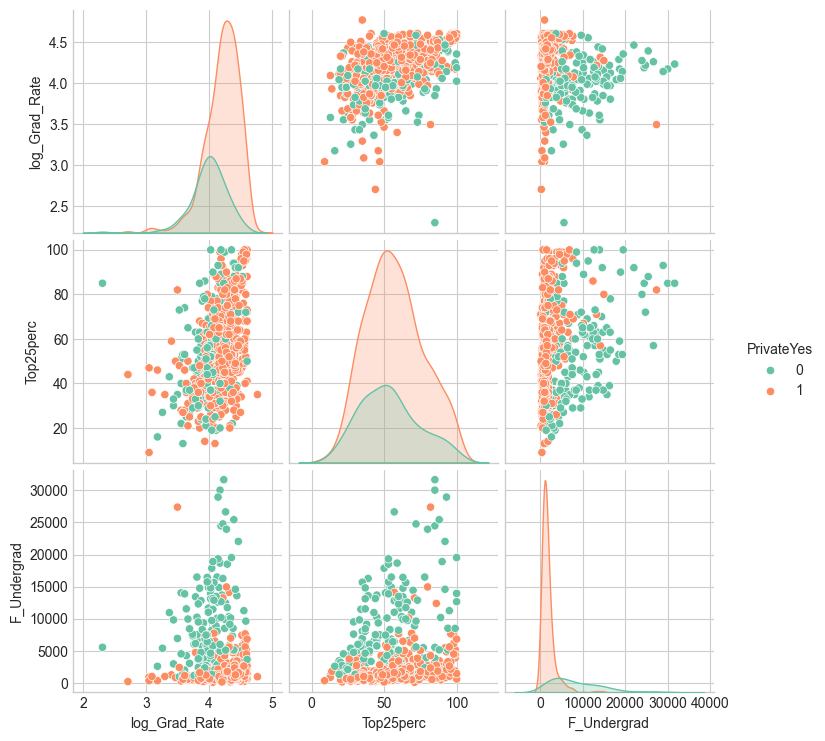

In [67]:
sns.pairplot(DF[['log_Grad_Rate', 'Top25perc', 'F_Undergrad', 'PrivateYes']], hue='PrivateYes')
plt.show()

In [69]:
corr_mat = DF.loc[DF['PrivateYes'] == 1][['log_Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,log_Grad_Rate,Top25perc,F_Undergrad
log_Grad_Rate,1.000000,0.456857,0.124258
Top25perc,0.456857,1.000000,0.317057
F_Undergrad,0.124258,0.317057,1.000000


In [70]:
corr_mat = DF.loc[DF['PrivateYes'] == 0][['log_Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,log_Grad_Rate,Top25perc,F_Undergrad
log_Grad_Rate,1.000000,0.352591,0.267969
Top25perc,0.352591,1.000000,0.441283
F_Undergrad,0.267969,0.441283,1.000000


### Строим модели регрессии 
#### Спецификация моделей
По итогам предварительного анализа данным можно предложить слудующие спецификации линейных регрессионных моделей:
1. `fit_lm_1`: $\hat{Grad\_Rate} = \hat{\beta_0}+ \hat{\beta_1} * PrivateYes + \hat{\beta_2} * Top25perc + \hat{\beta_3} * F\_Undergrad$
2. `fit_lm_2`: <br>$\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} * PrivateYes + \hat{\beta_2} * Top25perc * PrivateYes + \hat{\beta_3} * F\_Undergrad$
3. `fit_lm_3`: <br>$\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} * PrivateYes + \hat{\beta_2} * F\_Undergrad * PrivateYes + \hat{\beta_3} * Top25perc$
4. `fit_lm_4`: <br>$\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} * PrivateYes +$<br>$ + \hat{\beta_2} * Top25perc * PrivateYes + \hat{\beta_3} * F\_Undergrad * PrivateYes$
5. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_Grad\_Rate}$
6. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_Grad\_Rate}$
7. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_Grad\_Rate}$
8. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_Grad\_Rate}$

#### Обучение и интерпретация

In [71]:
df1 = DF[['Grad_Rate', 'PrivateYes', 'Top25perc', 'F_Undergrad']]

df2 = DF[['Grad_Rate', 'PrivateYes', 'Top25perc', 'F_Undergrad']]
df2.loc[:, 'Top25perc_PrivateYes'] = df2.loc[:, 'Top25perc'] * df2.loc[:, 'PrivateYes']
df2 = df2.drop('Top25perc', axis=1)

df3 = DF[['Grad_Rate', 'PrivateYes', 'Top25perc', 'F_Undergrad']]
df3.loc[:, 'F_Undergrad_PrivateYes'] = df3.loc[:, 'F_Undergrad'] * df3.loc[:, 'PrivateYes']
df3 = df3.drop('F_Undergrad', axis=1)

df4 = DF[['Grad_Rate', 'PrivateYes', 'Top25perc', 'F_Undergrad']]
df4.loc[:, 'Top25perc_PrivateYes'] = df4.loc[:, 'Top25perc'] * df4.loc[:, 'PrivateYes']
df4.loc[:, 'F_Undergrad_PrivateYes'] = df4.loc[:, 'F_Undergrad'] * df4.loc[:, 'PrivateYes']
df4 = df4.drop(['Top25perc', 'F_Undergrad'], axis=1)

#### Перекрестная оценка точности по блокам 

In [73]:
lm = skl_lm.LinearRegression()

folds = 10

r_state = np.arange(my_seed, my_seed + 9)

scores = list()

tic = time.perf_counter()
i = 0
for df in [df1, df2, df3, df4]:
	X = df.drop('Grad_Rate', axis=1)
	y = df.Grad_Rate
	kf_10 = KFold(n_splits=folds, random_state=r_state[i], shuffle=True)
	score = cross_val_score(lm, X, y, cv=kf_10, scoring='neg_mean_squared_error').mean()
	scores.append(score)
	i+=1

toc = time.perf_counter()
print(f'Расчеты методом CV по 10 блокам заняли {toc-tic:0.2f} секунд')

Расчеты методом CV по 10 блокам заняли 0.09 секунд


In [74]:
folds = 10

r_state = np.arange(my_seed, my_seed + 9)

scores_log = list()

tic = time.perf_counter()
i = 0
for df in [df1, df2, df3, df4]:
	X = df.drop('Grad_Rate', axis=1)
	y = np.log(df.Grad_Rate)
	kf_10 = KFold(n_splits=folds, random_state=r_state[i], shuffle=True)
	score = cross_val_score(lm, X, y, cv=kf_10, scoring='neg_mean_squared_error').mean()
	scores_log.append(score)
	i+=1

toc = time.perf_counter()
print(f'Расчеты методом CV по 10 блокам заняли {toc-tic:0.2f} секунд')

Расчеты методом CV по 10 блокам заняли 0.09 секунд


In [75]:
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели', fits[scores.index(max(scores))], ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_1 :
MSE_kf10 = 208.0


In [78]:
fits = ['fit_lm_1_log', 'fit_lm_2_log', 'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели', fits[scores_log.index(max(scores_log))], ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_1_log :
MSE_kf10 = 0.064


In [81]:
X = df1.drop('Grad_Rate', axis=1)
y = df1.Grad_Rate.values.reshape(-1,1)
fit_lm_1 = lm.fit(X,y)

y = DF_predict[['Grad_Rate']].values.reshape(-1, 1)

X = DF_predict[['PrivateYes', 'Top25perc', 'F_Undergrad']]

y_pred = fit_lm_1.predict(X)

MSE = sum((y - y_pred.reshape(-1,1))**2)/len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_1 на отложенных наблюдениях = 192.94


C:\Users\lyaze\AppData\Local\Temp\ipykernel_17772\3971099319.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)


In [83]:
X = df1.drop('Grad_Rate', axis=1)
y = np.log(df1.Grad_Rate).values.reshape(-1,1)
fit_lm_1_log = lm.fit(X,y)

y = np.log(DF_predict[['Grad_Rate']].values.reshape(-1, 1))

X = DF_predict[['PrivateYes', 'Top25perc', 'F_Undergrad']]

y_pred = fit_lm_1_log.predict(X)

MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1,1))**2)/len(y)
print('MSE модели fit_lm_1_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_1_log на отложенных наблюдениях = 185.10


C:\Users\lyaze\AppData\Local\Temp\ipykernel_17772\274437379.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_1_log на отложенных наблюдениях = %.2f' % MSE_log)


На выборке прогноз точнее у модели `fit_lm_1_log`: 
<br>$\hat{log\_Grad\_Rate} = \hat{\beta_0}+ \hat{\beta_1} * PrivateYes + \hat{\beta_2} * Top25perc + \hat{\beta_3} * F\_Undergrad$


In [86]:
X = df1.drop('Grad_Rate', axis=1)
y = np.log(df1.Grad_Rate).values.reshape(-1,1)
fit_lm_1_log = lm.fit(X,y)
print('модель fit_lm_1_log:\n', 'константа ', np.around(fit_lm_1_log.intercept_, 3), '\n объясняющие', list(df1.drop('Grad_Rate', axis=1).columns.values), '\n коэффициенты ', np.around(fit_lm_1_log.coef_, 3))

модель fit_lm_1_log:
 константа  [3.664] 
 объясняющие ['PrivateYes', 'Top25perc', 'F_Undergrad'] 
 коэффициенты  [[0.207 0.006 0.   ]]


### Прогноз на отложенные наблюдения по лучшей модели
Сделаем прогноз выпускного балла студента по модели `fit_lm_1_log` на отложенные наблюдения.

In [87]:
X = df1.drop('Grad_Rate', axis=1)
y = np.log(df1.Grad_Rate).values.reshape(-1,1)
fit_lm_1_log = lm.fit(X,y)

In [89]:
df1 = DF_predict
X = df1.drop('Grad_Rate', axis = 1)
y = np.log(df1.Grad_Rate).values.reshape(-1,1)

X = DF_predict[['PrivateYes', 'Top25perc', 'F_Undergrad']]
y_pred = fit_lm_1_log.predict(X)

MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1,1))**2)/len(y)
np.around(MSE_log, 2)

array([185.1])

In [90]:
print('Ошибка на отложенных наблюдениях составила ', np.around(np.sqrt(MSE_log)/np.mean(y)*100, 1)[0], '% от среднего значения Y', sep=' ')

Ошибка на отложенных наблюдениях составила  332.2 % от среднего значения Y
